# First Analysis of Results from Exact Diagonalization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hydra
import h5py
import os

from hydra import compose, initialize
from omegaconf import OmegaConf

In [2]:
from typing import Callable

# every argument after * must be passed as a keyword argument
def plot_xy(
    x: np.ndarray,
    y: np.ndarray,
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Callable | None = None,
    guide_label: str | None = None
):
    """
    Generic plotting helper.

    Parameters
    ----------
    x, y : array-like
        Data to plot.
    xlabel, ylabel, title : str
        Axis labels and title.
    loglog : bool
        If True, make a log-log plot.
    guide_line : callable
        A function f(x) that returns a reference line to plot.
    guide_label : str
        Label for the reference line.
    """
    plt.figure()

    if loglog:
        plt.loglog(x, y, label=ylabel)
        if guide_line is not None:
            plt.loglog(x, guide_line(x), 'k--', label=guide_label)
    else:
        plt.plot(x, y, label=ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def plot_photon_number_vs_omega(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency"
    )

def plot_photon_number_vs_omega_log_log(omega_list, photon_numbers):
    plot_xy(
        omega_list, photon_numbers,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Photon Frequency (Log-Log Scale)",
        loglog=True
    )

def plot_entanglement_entropy_vs_omega_log_log(omega_list, entropies):
    plot_xy(
        omega_list, entropies,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Photon Frequency (Log-Log Scale)",
        loglog=True,
        guide_line=lambda x: 1/x**2,
        guide_label=r'$1/\Omega^2$'
    )

def plot_photon_number_vs_U(U_list, photon_numbers):
    plot_xy(
        U_list, photon_numbers,
        xlabel='Interaction Strength U',
        ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
        title="Photon Number vs Interaction Strength U"
    )

def plot_entanglement_entropy_vs_U(U_list, entropies):
    plot_xy(
        U_list, entropies,
        xlabel='Interaction Strength U',
        ylabel='Entanglement Entropy',
        title="Entanglement Entropy vs Interaction Strength U"
    )


def plot_correlation_differences_vs_U(U_list, correlation_differences):
    plot_xy(
        U_list, correlation_differences,
        xlabel='Interaction Strength U',
        ylabel='Correlation Differences',
        title="Correlation Differences vs Interaction Strength U"
    )


def plot_ground_state_amplitudes_vs_U(U_list: np.ndarray, ground_states: np.ndarray):
    # plot the absolute square of the ground state coefficients per sites for various U
    # as a colormap. Start at the top of the plot with the lowest U and go down to highest U
    plt.figure()
    plt.imshow(np.abs(ground_states)**2, aspect='auto', extent=[0, len(ground_states[0]), U_list[-1], U_list[0]]) # type: ignore
    plt.colorbar(label='|Coefficient|^2')
    plt.xlabel('Basis State Index')
    plt.ylabel('Interaction Strength U')
    plt.title('Ground State Coefficients vs Interaction Strength U')
    plt.show()


# def plot_ground_state_vs_U(basis: Basis, U_list: np.ndarray, ground_states: np.ndarray):
#     # assume that we have purely fermionic basis for now
#     # take the state with the highest amplitude in each ground state, obtain its binaray representation
#     # and plot its occupation per site vs U
#     L = basis.L
#     dominant_states = []
#     for gs in ground_states:
#         max_idx = np.argmax(np.abs(gs))
#         dominant_state = basis.states[max_idx]
#         dominant_states.append(dominant_state)

#     plt.figure()
#     for site in range(L):
#         occupations = [(state[0] >> site) & 1 for state in dominant_states]
#         plt.plot(U_list, occupations, label=f'Site {site}')
#     plt.xlabel('Interaction Strength U')
#     plt.ylabel('Occupation')
#     plt.title('Dominant Ground State Occupation vs Interaction Strength U')
#     plt.legend()
#     plt.grid()
#     plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional


def plot_multi_xy(
    curves: list[tuple[np.ndarray, np.ndarray, str]],
    *,
    xlabel: str,
    ylabel: str,
    title: str,
    loglog: bool = False,
    guide_line: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    guide_label: Optional[str] = None,
):
    """
    Plot multiple (x, y) curves in a single figure.

    curves: list of (x, y, label) tuples
    """
    plt.figure()

    # Plot optional guide function (must use the x-values of the first curve)
    if loglog and guide_line is not None:
        x0, _, _ = curves[0]
        plt.loglog(x0, guide_line(x0), 'k--', label=guide_label)

    # Plot each curve
    for x, y, label in curves:
        if loglog:
            plt.loglog(x, y, label=label)
        else:
            plt.plot(x, y, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def plot_observable_vs_U_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        U_list, photon_nums = results
        curves.append((U_list, photon_nums, f"N_ph={N_ph}"))

    plot_multi_xy(
        curves,
        xlabel="U",
        ylabel=observable,
        title=f"{observable} vs U for Different Photon Cutoffs",
    )

def loglog_plot_observable_vs_omega_multi(results_dict, observable):
    curves = []
    for N_ph, results in results_dict.items():
        omega_list, entropies = results
        curves.append((omega_list, entropies, f"N_ph={N_ph}"))

    if observable == "entanglement_entropy":
        guide_line=lambda x: 1/x**2
        guide_label=r'$\propto 1/\Omega^2$'
    else:
        guide_line=None
        guide_label=None

    plot_multi_xy(
        curves,
        xlabel=r'Photon Frequency $\Omega$',
        ylabel=observable,
        title=f'{observable} vs Omega (Different Photon Cutoffs)',
        loglog=True,
        guide_line=guide_line,
        guide_label=guide_label
    )





In [4]:
initialize(version_base=None, config_path="../../conf")
cfg = compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

method:
  name: exact_diagonalization
seed: 42
root_data_dir: /data/xxz_cavity/${method.name}/
system:
  L: 4
  N_f: null
  N_ph: 2
  boundary_conditions: periodic
sweeps:
  photon_number:
    U_sweep:
      parameters:
        t: 1.0
        g: 0.5
        omega: 10.0
        U_min: 0.0
        U_max: 20.0
        U_points: 100
    omega_sweep:
      parameters:
        t: 1.0
        g: 0.5
        U: 3.0
        omega_min: 1.0
        omega_max: 100.0
        omega_points: 13
  entanglement_entropy:
    U_sweep:
      parameters:
        t: ${sweeps.photon_number.U_sweep.parameters.t}
        g: ${sweeps.photon_number.U_sweep.parameters.g}
        omega: ${sweeps.photon_number.U_sweep.parameters.omega}
        U_min: ${sweeps.photon_number.U_sweep.parameters.U_min}
        U_max: ${sweeps.photon_number.U_sweep.parameters.U_max}
        U_points: ${sweeps.photon_number.U_sweep.parameters.U_points}
    omega_sweep:
      parameters:
        t: ${sweeps.photon_number.omega_sweep.parame

In [5]:
def print_hdf5_tree(filename):
    def print_attrs(name, obj):
        print(name)
        # for key, val in obj.attrs.items():
        #     print(f"  [ATTR] {key}: {val}")
        if isinstance(obj, h5py.Dataset):
            print(f"  [DATASET] shape={obj.shape}, dtype={obj.dtype}")
    with h5py.File(filename, "r") as f:
        f.visititems(print_attrs)


In [57]:
root_data_dir = cfg.root_data_dir
sweep = "U_sweep"
print(f"Root data directory: {root_data_dir}")
filename = f"ed_results_{sweep}.h5"
data_path = os.path.join(root_data_dir, filename)
print_hdf5_tree(data_path)

Root data directory: /data/xxz_cavity/exact_diagonalization/
L=10_N_f=5_N_ph=16_boundary_conditions=open_t=1.0_g=0.3_omega=1.0
L=10_N_f=5_N_ph=16_boundary_conditions=open_t=1.0_g=0.3_omega=1.0/longest_range_correlation
  [DATASET] shape=(2, 50), dtype=float64
L=10_N_f=5_N_ph=16_boundary_conditions=open_t=1.0_g=0.5_omega=10.0
L=10_N_f=5_N_ph=16_boundary_conditions=open_t=1.0_g=0.5_omega=10.0/entanglement_entropy
  [DATASET] shape=(2, 100), dtype=float64
L=10_N_f=5_N_ph=16_boundary_conditions=open_t=1.0_g=0.5_omega=10.0/photon_number
  [DATASET] shape=(2, 100), dtype=float64
L=10_N_f=5_N_ph=16_boundary_conditions=periodic_t=1.0_g=0.3_omega=1.0
L=10_N_f=5_N_ph=16_boundary_conditions=periodic_t=1.0_g=0.3_omega=1.0/longest_range_correlation
  [DATASET] shape=(2, 50), dtype=float64
L=10_N_f=5_N_ph=16_boundary_conditions=periodic_t=1.0_g=0.5_omega=10.0
L=10_N_f=5_N_ph=16_boundary_conditions=periodic_t=1.0_g=0.5_omega=10.0/entanglement_entropy
  [DATASET] shape=(2, 100), dtype=float64
L=10_N_f

In [53]:
photon_cutoffs = [18]  # , 8, 10, 12, 14, 16
L = 8
N_f = L // 2
results_all_photon_cutoffs = {"photon_number": {}, "entanglement_entropy": {}}

def make_group_name(L, N_f, N_ph, sweep, boundary_conditions="periodic", t=1.0, g=0.5):
    """Construct HDF5 group names consistently."""
    base = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t={t}_g={g}"
    if sweep == "U_sweep":
        return f"{base}_omega=10.0"
    elif sweep == "omega_sweep":
        return f"{base}_U=3.0"
    else:
        raise ValueError(f"Unknown sweep: {sweep}")

boundary_conditions = "open"

for N_ph in photon_cutoffs:
    group_photon = make_group_name(L, N_f, N_ph, sweep, boundary_conditions=boundary_conditions)
    group_entropy = make_group_name(L, N_f, N_ph, sweep, boundary_conditions=boundary_conditions)
    with h5py.File(data_path, "r") as f:
        # --- photon number ---
        print(f"Loading data for N_ph={N_ph} from groups: {group_photon} and {group_entropy}")
        ds_photon = f[f"{group_photon}/photon_number"]
        assert isinstance(ds_photon, h5py.Dataset)
        photon_data = ds_photon[()]
        results_all_photon_cutoffs["photon_number"][N_ph] = photon_data

        # --- entanglement entropy ---
        ds_entropy = f[f"{group_entropy}/entanglement_entropy"]
        assert isinstance(ds_entropy, h5py.Dataset)
        entropy_data = ds_entropy[()]
        results_all_photon_cutoffs["entanglement_entropy"][N_ph] = entropy_data


Loading data for N_ph=18 from groups: L=8_N_f=4_N_ph=18_boundary_conditions=open_t=1.0_g=0.5_omega=10.0 and L=8_N_f=4_N_ph=18_boundary_conditions=open_t=1.0_g=0.5_omega=10.0


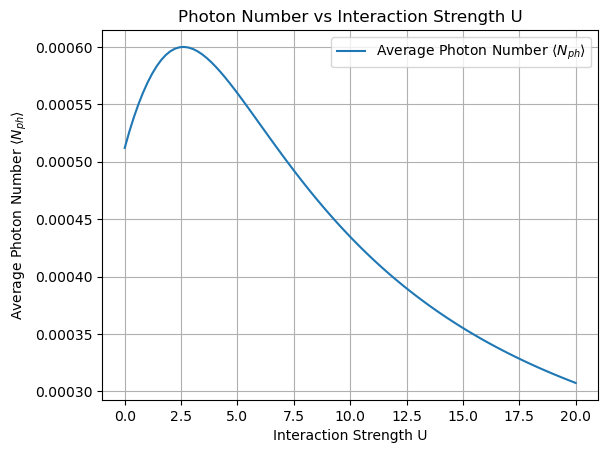

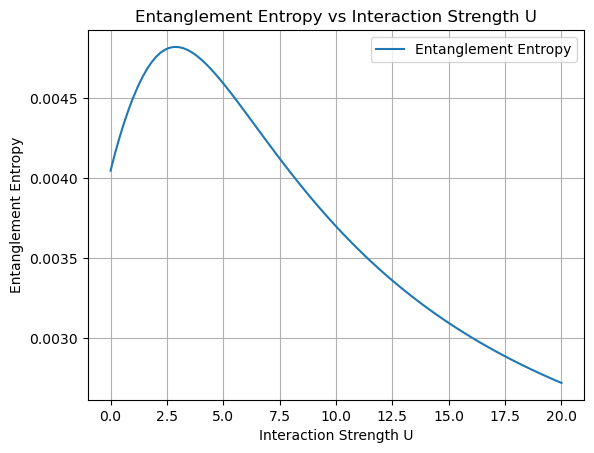

In [54]:
# take results for highest photon cutoff and plot them separately
N_ph_max = max(photon_cutoffs)
x_vals, photon_numbers = results_all_photon_cutoffs["photon_number"][N_ph_max]
x_vals, entropies = results_all_photon_cutoffs["entanglement_entropy"][N_ph_max]

if sweep == "U_sweep":
    plot_photon_number_vs_U(x_vals, photon_numbers)
    plot_entanglement_entropy_vs_U(x_vals, entropies)
elif sweep == "omega_sweep":
    plot_photon_number_vs_omega_log_log(x_vals, photon_numbers)
    plot_entanglement_entropy_vs_omega_log_log(x_vals, entropies)

In [58]:
observable = "longest_range_correlation"
results_all_photon_cutoffs = {"g_zero": {}, "g_finite": {}}
boundary_conditions = "open"
# L=8_N_f=4_N_ph=18_boundary_conditions=open_t=1.0_g=0_omega=1.0/longest_range_correlation
# L=8_N_f=4_N_ph=18_boundary_conditions=periodic_t=1.0_g=0.3_omega=1.0/longest_range_correlation
for N_ph in photon_cutoffs:
    
    group_name = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t=1.0_g=0.3_omega=1.0"
    group_name_g_zero = f"L={L}_N_f={N_f}_N_ph={N_ph}_boundary_conditions={boundary_conditions}_t=1.0_g=0_omega=1.0"
    # get data from hdf5 file
    print(f"Loading data for N_ph={N_ph} from group: {group_name}")
    with h5py.File(data_path, "r") as f:
        obj = f[f"{group_name}/{observable}"]
        assert isinstance(obj, h5py.Dataset), f"Expected h5py.Dataset, got {type(obj)}"
        results = obj[()]
        print(f"Results shape: {results.shape}")
        print(f"first 5 results: {results[0][0:5]}\n{results[1][0:5]}")
        results_all_photon_cutoffs["g_finite"][N_ph] = results

    print(f"Loading data for N_ph={N_ph} from group: {group_name_g_zero}")
    with h5py.File(data_path, "r") as f:
        obj = f[f"{group_name_g_zero}/{observable}"]
        assert isinstance(obj, h5py.Dataset), f"Expected h5py.Dataset, got {type(obj)}"
        results = obj[()]
        print(f"Results shape: {results.shape}")
        print(f"first 5 results: {results[0][0:5]}\n{results[1][0:5]}")
        results_all_photon_cutoffs["g_zero"][N_ph] = results

Loading data for N_ph=18 from group: L=8_N_f=4_N_ph=18_boundary_conditions=open_t=1.0_g=0.3_omega=1.0
Results shape: (2, 50)
first 5 results: [0.         0.08163265 0.16326531 0.24489796 0.32653061]
[0.24987657 0.25490507 0.25979953 0.26455632 0.26917208]
Loading data for N_ph=18 from group: L=8_N_f=4_N_ph=18_boundary_conditions=open_t=1.0_g=0_omega=1.0
Results shape: (2, 50)
first 5 results: [0.         0.08163265 0.16326531 0.24489796 0.32653061]
[0.25       0.25501376 0.25989538 0.26464124 0.26924793]


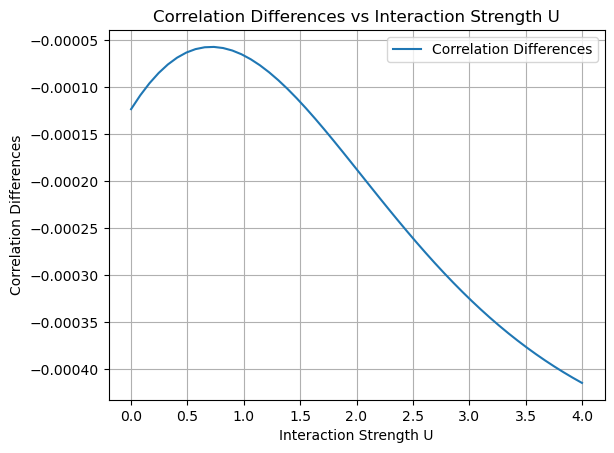

In [60]:
max_n_ph = max(photon_cutoffs)
U_list = results_all_photon_cutoffs["g_finite"][max_n_ph][0]

g_finite_minus_g_zero = results_all_photon_cutoffs["g_finite"][max_n_ph][1] - results_all_photon_cutoffs["g_zero"][max_n_ph][1]
plot_correlation_differences_vs_U(U_list, g_finite_minus_g_zero)


## Convergence Checks

In [43]:
root_data_dir = cfg.root_data_dir
print(f"Root data directory: {root_data_dir}")
filename = "ed_results_N_ph_convergence.h5"
data_path = os.path.join(root_data_dir, filename)
print_hdf5_tree(data_path)

Root data directory: /data/xxz_cavity/exact_diagonalization/
L=10_N_f=5_boundary_conditions=open_t=1.0_U=2.4_g=4.0_omega=1.0
L=10_N_f=5_boundary_conditions=open_t=1.0_U=2.4_g=4.0_omega=1.0/entanglement_entropy
  [DATASET] shape=(2, 16), dtype=float64
L=10_N_f=5_boundary_conditions=open_t=1.0_U=2.4_g=4.0_omega=1.0/longest_range_correlation
  [DATASET] shape=(2, 16), dtype=float64
L=10_N_f=5_boundary_conditions=open_t=1.0_U=2.4_g=4.0_omega=1.0/photon_number
  [DATASET] shape=(2, 16), dtype=float64
L=10_N_f=5_boundary_conditions=periodic_t=1.0_U=2.4_g=4.0_omega=1.0
L=10_N_f=5_boundary_conditions=periodic_t=1.0_U=2.4_g=4.0_omega=1.0/entanglement_entropy
  [DATASET] shape=(2, 16), dtype=float64
L=10_N_f=5_boundary_conditions=periodic_t=1.0_U=2.4_g=4.0_omega=1.0/longest_range_correlation
  [DATASET] shape=(2, 16), dtype=float64
L=10_N_f=5_boundary_conditions=periodic_t=1.0_U=2.4_g=4.0_omega=1.0/photon_number
  [DATASET] shape=(2, 16), dtype=float64
L=12_N_f=6_boundary_conditions=periodic_t=1

In [50]:
photon_cutoffs = cfg.convergence_checks.photon_number_cutoffs
L = 8
N_f = L // 2
boundary_conditions = "open"
group_name = f"L={L}_N_f={N_f}_boundary_conditions={boundary_conditions}_t=1.0_U=2.4_g=4.0_omega=1.0"
results_all_observables = {}

for observable in cfg.convergence_checks.observables:
    # get data from hdf5 file
    print(f"Loading data for observable={observable} ")
    with h5py.File(data_path, "r") as f:
        obj = f[f"{group_name}/{observable}"]
        assert isinstance(obj, h5py.Dataset), f"Expected h5py.Dataset, got {type(obj)}"
        results = obj[()]
        print(f"Results shape: {results.shape}")
        print(f"first 5 results: {results[0][0:5]}\n{results[1][0:5]}")
        results_all_observables[observable] = results

Loading data for observable=photon_number 
Results shape: (2, 20)
first 5 results: [0. 2. 4. 6. 8.]
[0.         0.4360926  0.59760441 0.56782203 0.51696977]
Loading data for observable=entanglement_entropy 
Results shape: (2, 20)
first 5 results: [0. 2. 4. 6. 8.]
[-1.33226763e-15  3.52962538e-02  1.84477445e-01  2.09001402e-01
  2.76284852e-01]
Loading data for observable=longest_range_correlation 
Results shape: (2, 20)
first 5 results: [0. 2. 4. 6. 8.]
[0.33841009 0.3421901  0.35890805 0.35324155 0.3346605 ]


In [13]:
results_all_observables['photon_number'][0]

array([ 0.,  2.,  4.,  6.,  8., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20.])

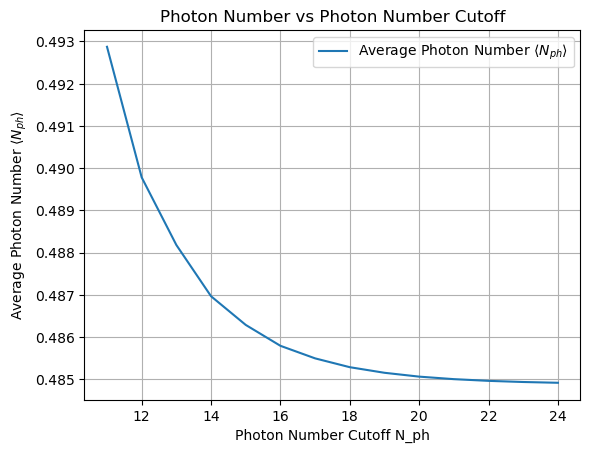

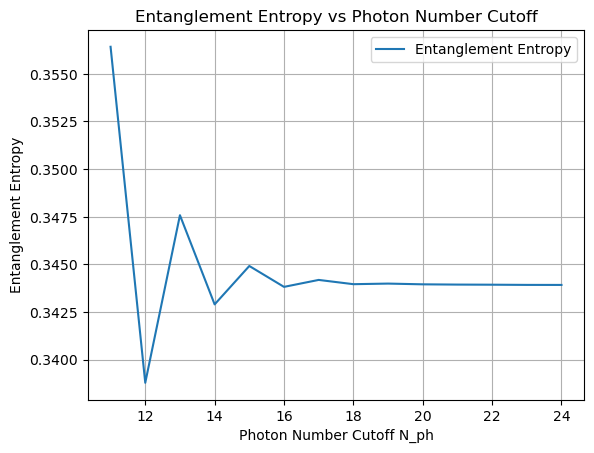

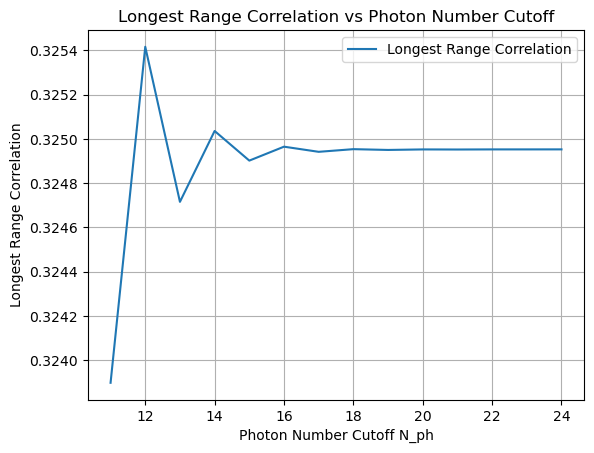

In [51]:
n_start = 6

# make plots for each observable
for observable, results in results_all_observables.items():
    # throw away the first n_start data points
    results = (results[0][n_start:], results[1][n_start:])
    if observable == "photon_number":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel=r'Average Photon Number $\langle N_{ph} \rangle$',
            title='Photon Number vs Photon Number Cutoff'
        )
    elif observable == "entanglement_entropy":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel='Entanglement Entropy',
            title='Entanglement Entropy vs Photon Number Cutoff'
        )
    elif observable == "longest_range_correlation":
        plot_xy(
            results[0], results[1],
            xlabel='Photon Number Cutoff N_ph',
            ylabel='Longest Range Correlation',
            title='Longest Range Correlation vs Photon Number Cutoff'
        )